In [1]:
#read data

SegerMatrix   <- readRDS(url("https://storage.googleapis.com/cellid-cbl/SegerstolpeMatrix.rds"))
SegerMetaData <- readRDS(url("https://storage.googleapis.com/cellid-cbl/SegerstolpeMetaData2.rds"))

data=t(as.matrix(SegerMatrix))
annotation=SegerMetaData

annotation$celltype=annotation$cell.type


Loading required package: Matrix



In [38]:
extract_prediction_label = function(x){
    y=c()
    for (i in x){
        y=c(y,i)
    }
    y
    return(y)
}



calculate_test_accuracy <- function(true_labels, predicted_labels) {
  if (length(true_labels) != length(predicted_labels)) {
    stop("Input vectors must have the same length.")
  }
  
  correct_predictions <- sum(true_labels == predicted_labels)
  total_samples <- length(true_labels)
  
  accuracy <- correct_predictions / total_samples
  return(accuracy)
}


calculate_f1_score_multiclass <- function(true_labels, predicted_labels) {
  if (length(true_labels) != length(predicted_labels)) {
    stop("Input vectors must have the same length.")
  }
  
  # Get unique class labels
  classes <- unique(c(true_labels, predicted_labels))
  
  # Initialize variables to store per-class statistics
  precision <- numeric(length(classes))
  recall <- numeric(length(classes))
  f1_score <- numeric(length(classes))
  
  # Calculate precision, recall, and F1 score for each class
  for (i in 1:length(classes)) {
    class_label <- classes[i]
    true_positive <- sum(predicted_labels == class_label & true_labels == class_label)
    false_positive <- sum(predicted_labels == class_label & true_labels != class_label)
    false_negative <- sum(predicted_labels != class_label & true_labels == class_label)
    
    precision[i] <- true_positive / (true_positive + false_positive)
    recall[i] <- true_positive / (true_positive + false_negative)
    
    f1_score[i] <- 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
  }
  
  # Calculate macro-averaged F1 score
  macro_f1_score <- mean(f1_score, na.rm = TRUE)
  
  return(macro_f1_score)
}




Warning message in split.default(sample(nrow(data)), 1:num_folds):
“data length is not a multiple of split variable”


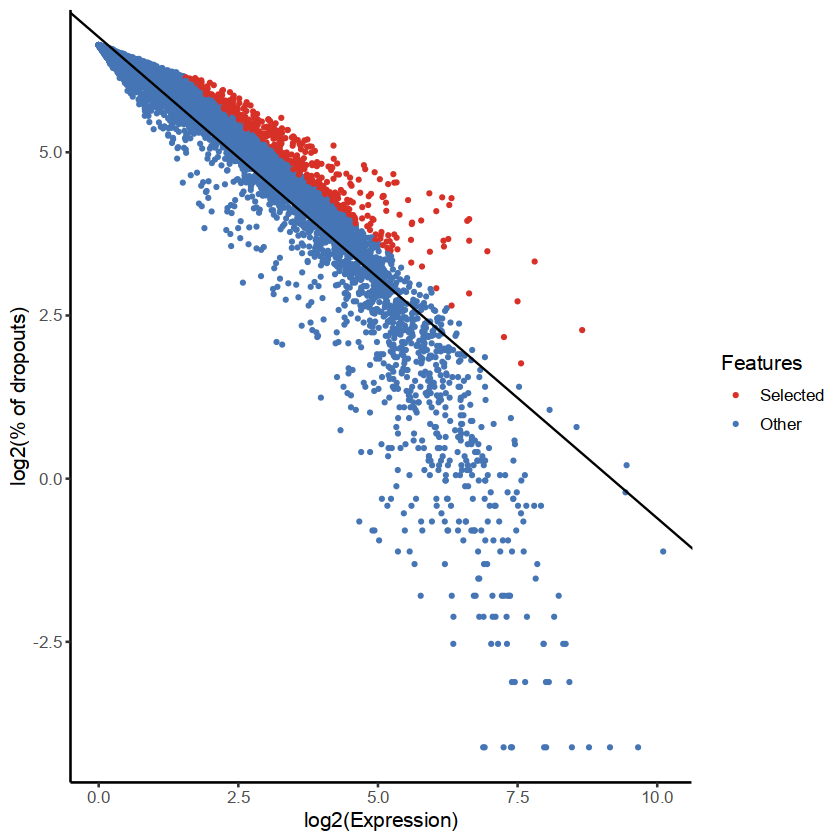

Fold 1 : Train samples = 1734 , Test samples = 434 Accuracy: 0.9539171 F1 score: 0.9225795 


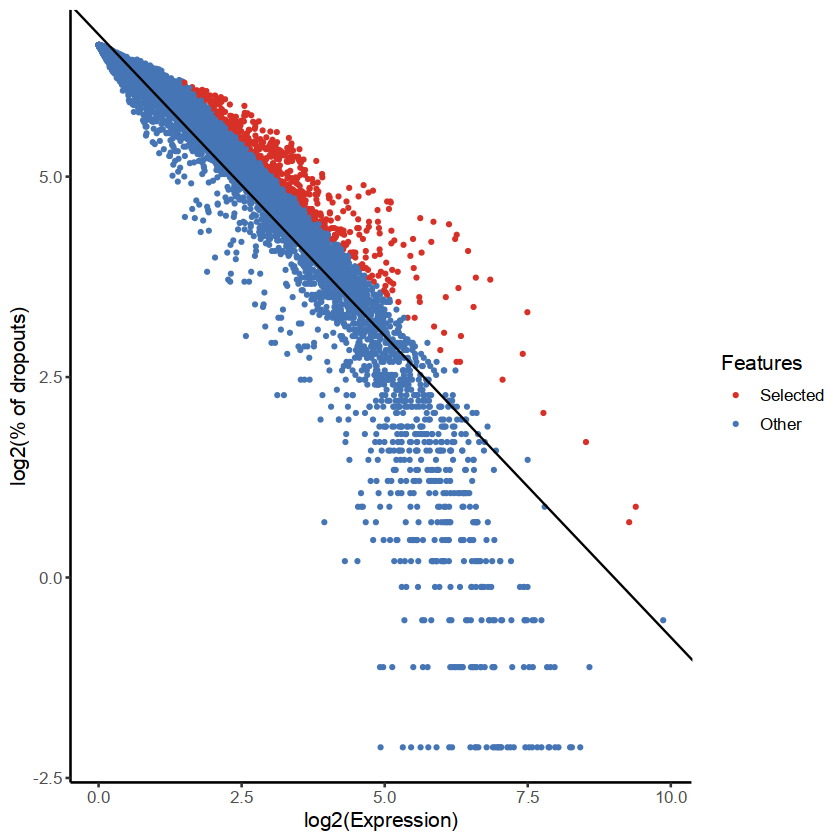

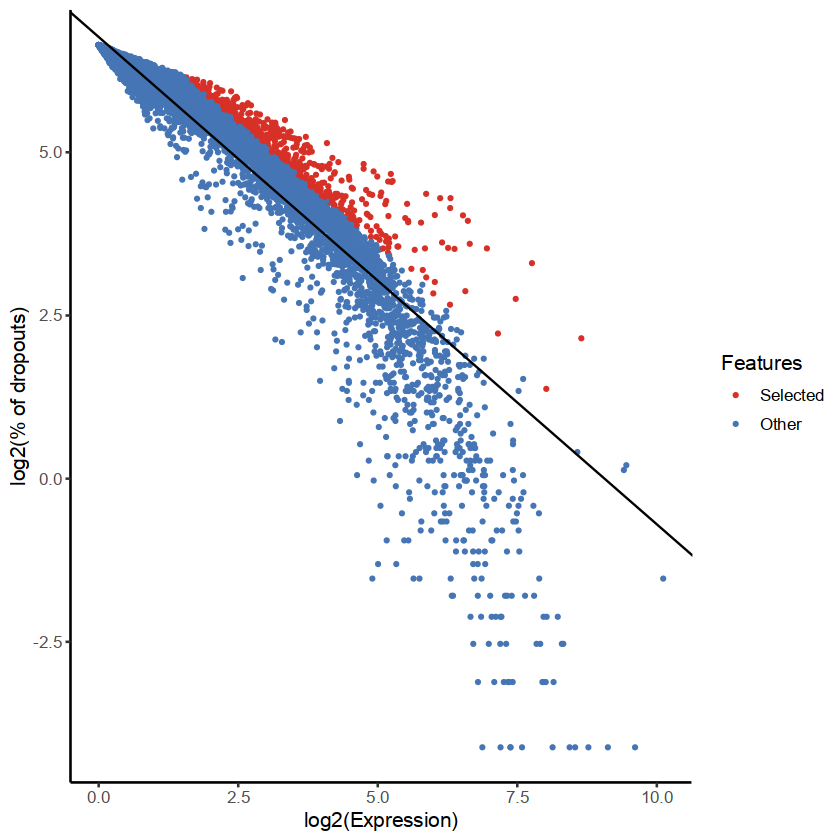

Fold 2 : Train samples = 1734 , Test samples = 434 Accuracy: 0.9539171 F1 score: 0.9099801 


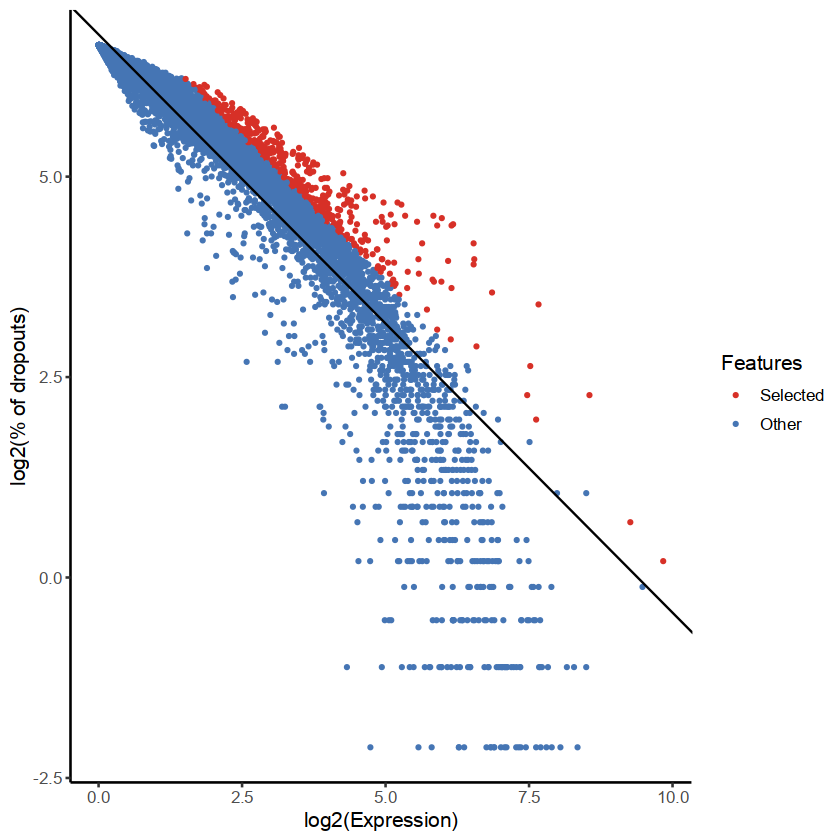

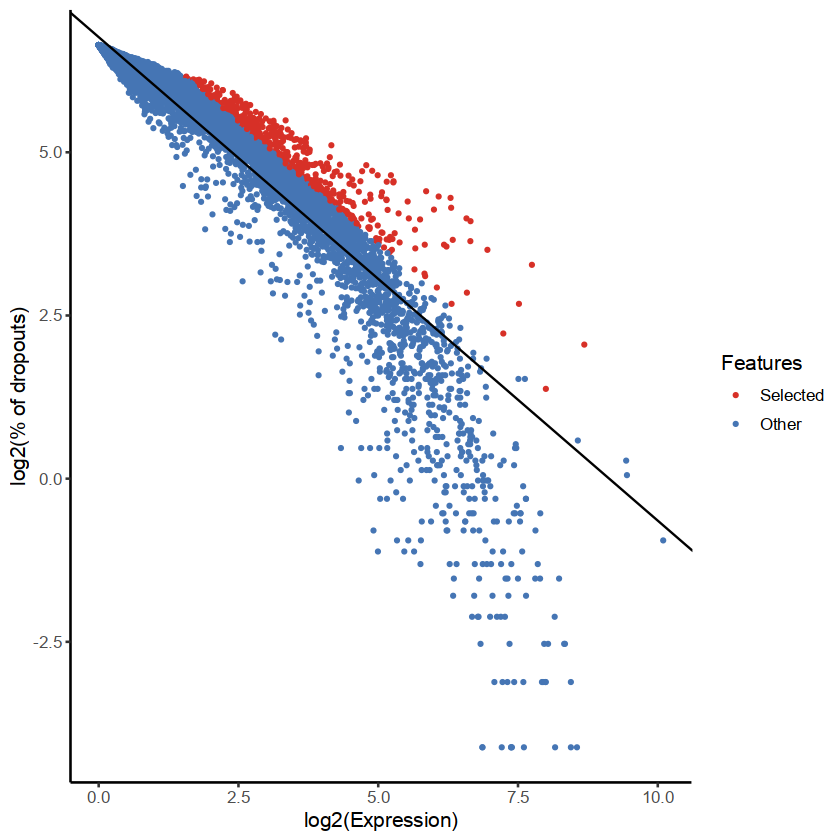

Fold 3 : Train samples = 1734 , Test samples = 434 Accuracy: 0.937788 F1 score: 0.9361012 


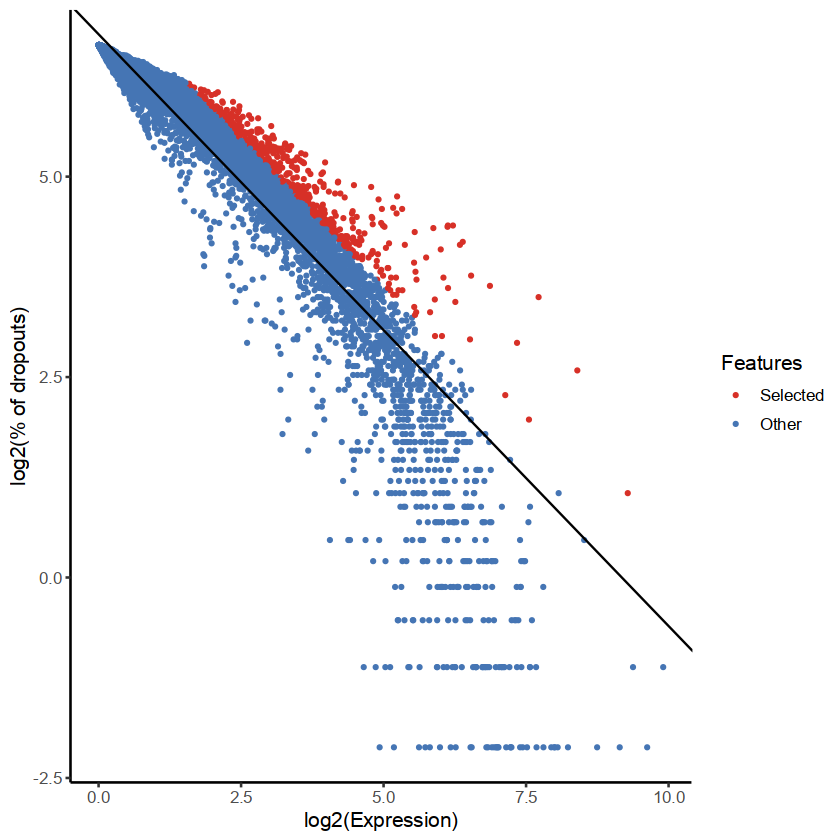

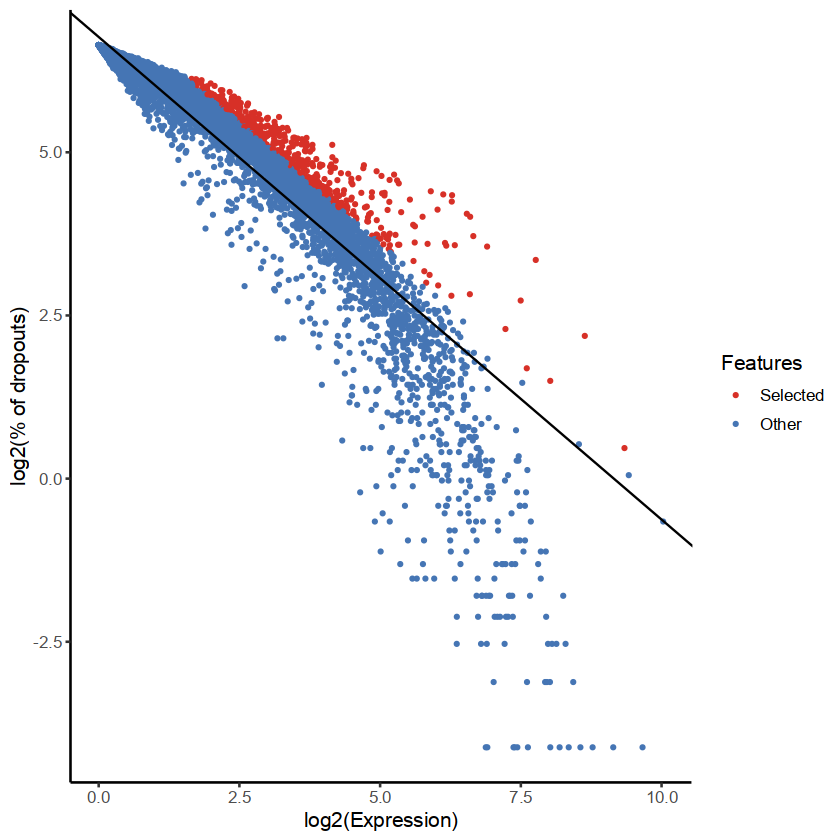

Fold 4 : Train samples = 1735 , Test samples = 433 Accuracy: 0.9561201 F1 score: 0.9798666 


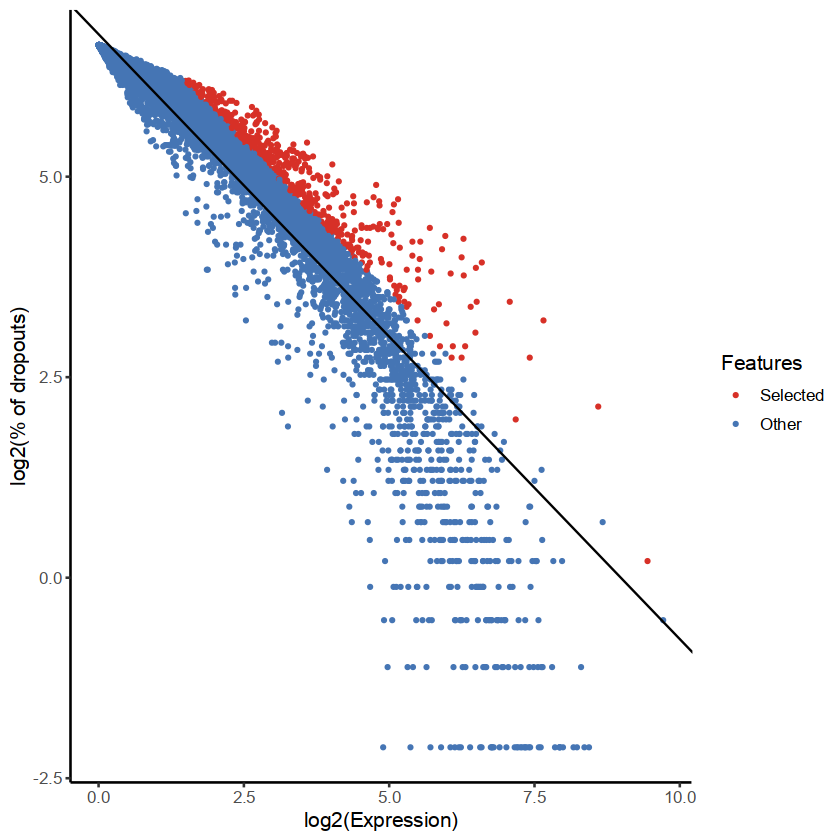

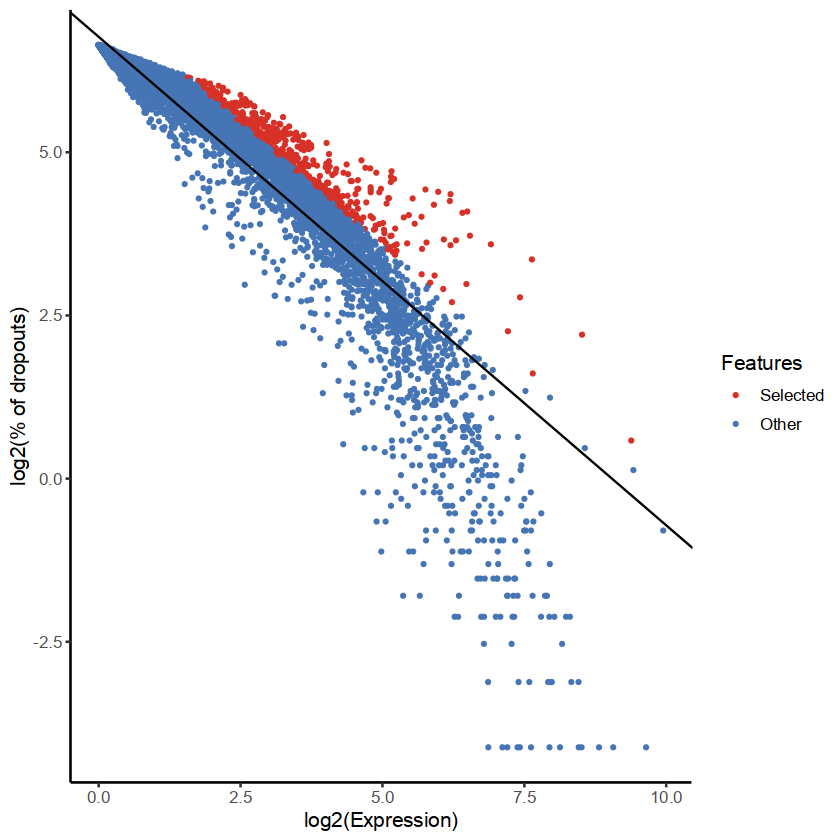

Fold 5 : Train samples = 1735 , Test samples = 433 Accuracy: 0.9630485 F1 score: 0.9699126 


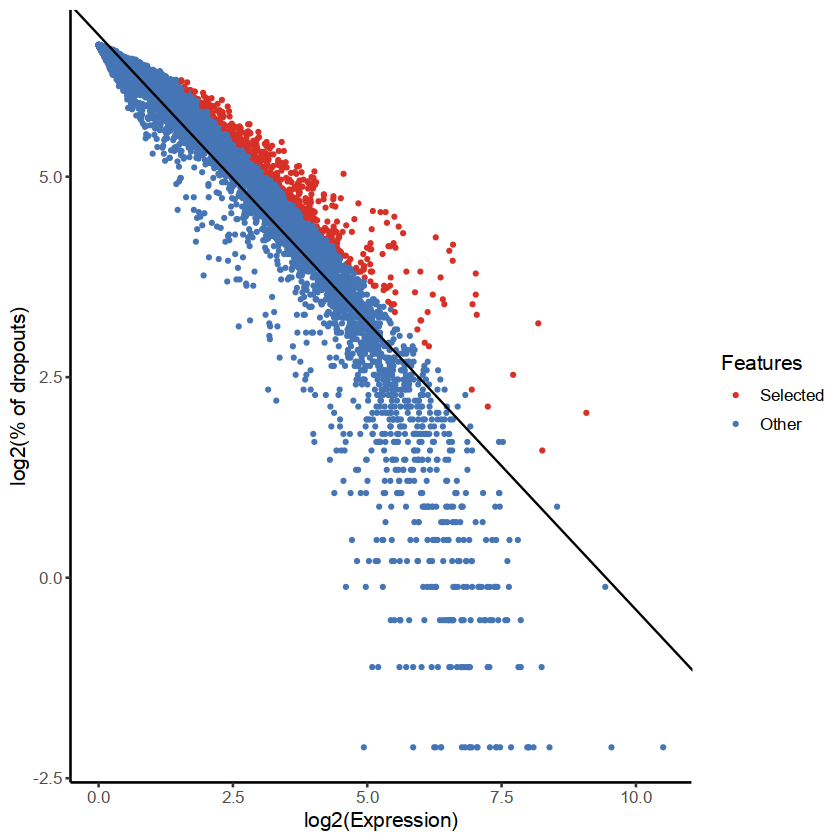

In [39]:
library(SingleCellExperiment)
library(scmap)

num_folds <- 5

# Generate 5-fold cross-validation indices
fold_indices <- split(sample(nrow(data)), 1:num_folds)

# Perform 5-fold cross-validation
for (i in 1:num_folds) {
  # Get indices for the current fold
  test_indices <- fold_indices[[i]]
  train_indices <- unlist(fold_indices[-i])
  
  # Subset data and annotation based on indices
  data_train <- data[train_indices, ]
  anno_train <- annotation[train_indices, ]
  
  data_test <- data[test_indices, ]
  anno_test <- annotation[test_indices, ]

  anno_train$cell_type1=anno_train$celltype

  reference = SingleCellExperiment(assays = list(counts = t(data_train)),colData = anno_train["cell_type1"])

  logcounts(reference) <- log2(counts(reference) + 1)

  rowData(reference)$feature_symbol <- rownames(reference)
  
  reference <- selectFeatures(reference, suppress_plot = FALSE)

  reference <- indexCluster(reference)



  query = SingleCellExperiment(assays = list(counts = t(data_test)))

  logcounts(query) <- log2(counts(query) + 1)

  rowData(query)$feature_symbol <- rownames(query)

  query <- selectFeatures(query, suppress_plot = FALSE)

  #query <- indexCluster(query)



  scmapCluster_results <- scmapCluster(
  projection = query, 
  index_list = list(
    yan = metadata(reference)$scmap_cluster_index
    )
  )
  predictions=as.vector(scmapCluster_results$scmap_cluster_labs)

  acc = calculate_test_accuracy(predictions,anno_test$celltype)
  f1_score = calculate_f1_score_multiclass(predictions,anno_test$celltype)

  cat("Fold", i, ": Train samples =", nrow(data_train), ", Test samples =", nrow(data_test), "Accuracy:", acc,"F1 score:", f1_score, "\n")

}

Warning message in split.default(sample(nrow(data)), 1:num_folds):
“data length is not a multiple of split variable”


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



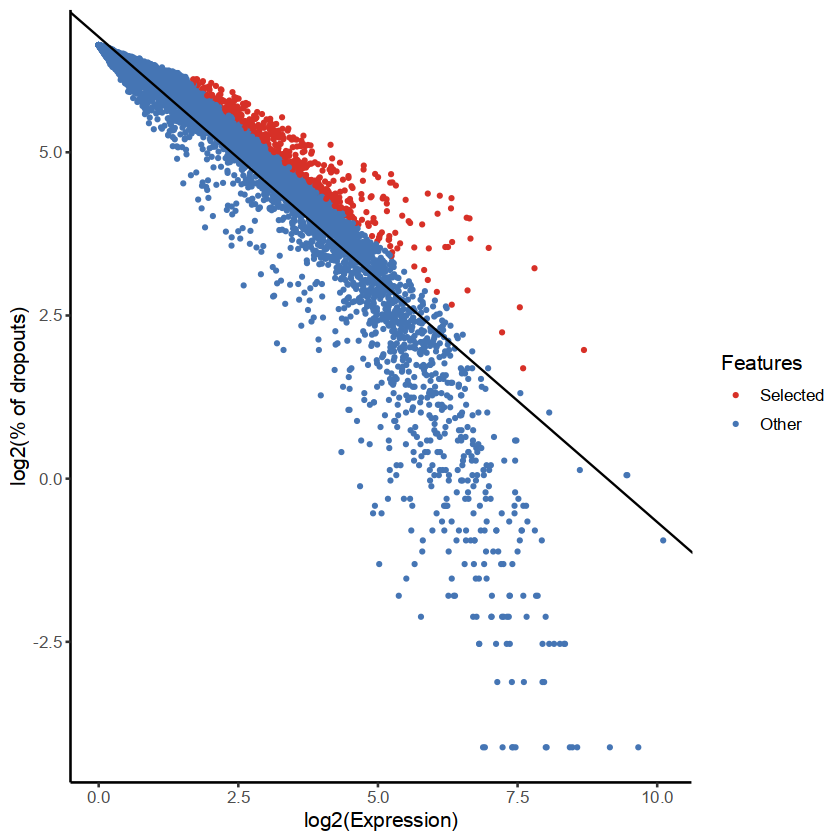

Fold 1 : Train samples = 1734 , Test samples = 434 Accuracy: 0.9470046 F1 score: 0.8699191 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



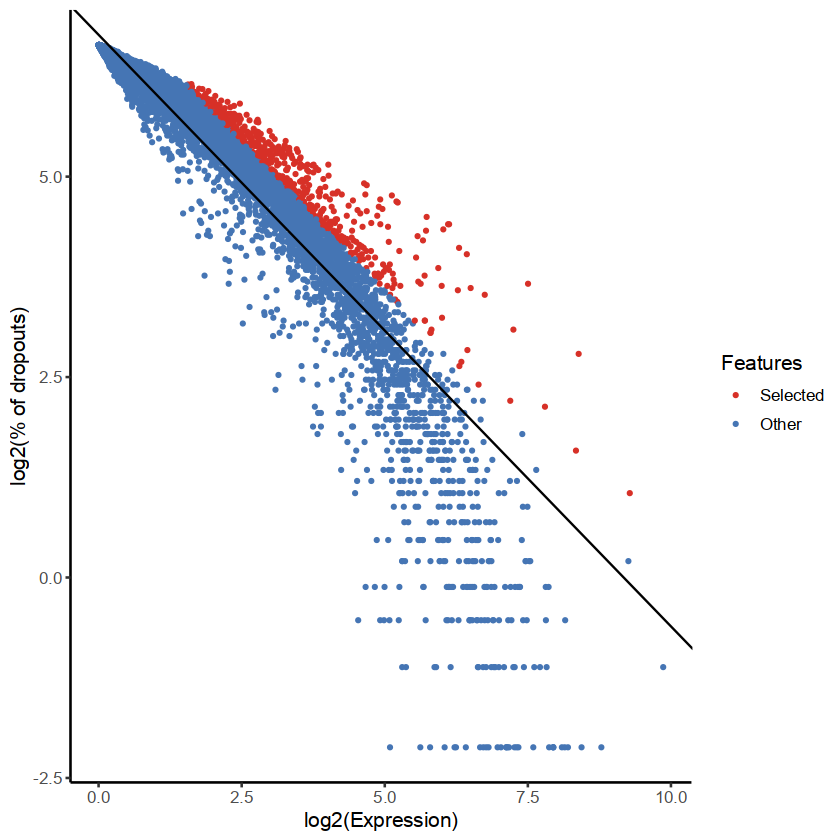

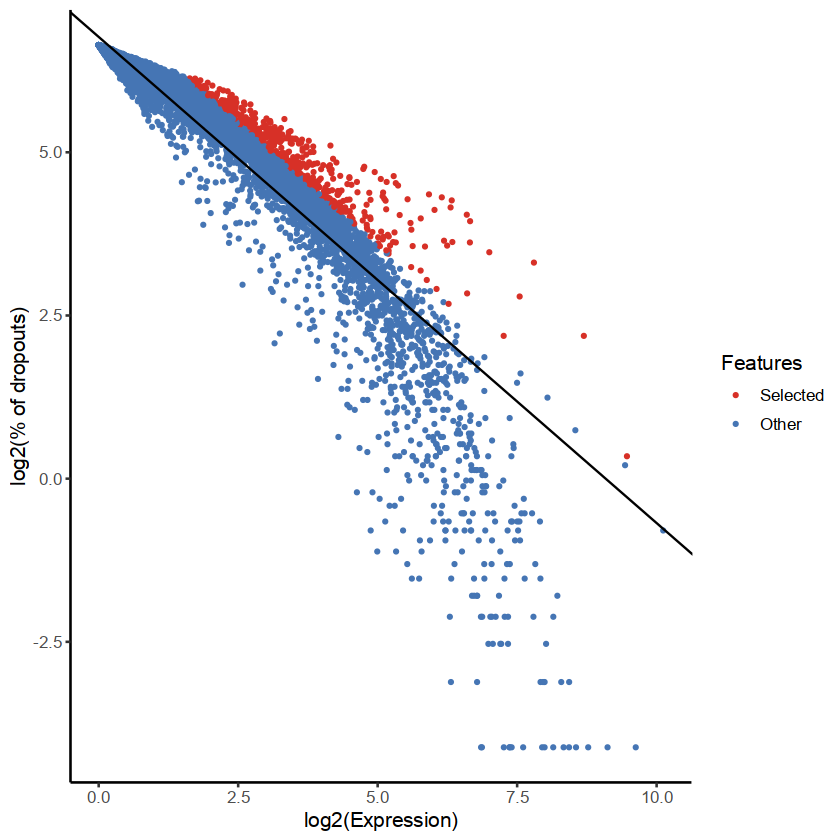

Fold 2 : Train samples = 1734 , Test samples = 434 Accuracy: 0.9516129 F1 score: 0.9215818 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



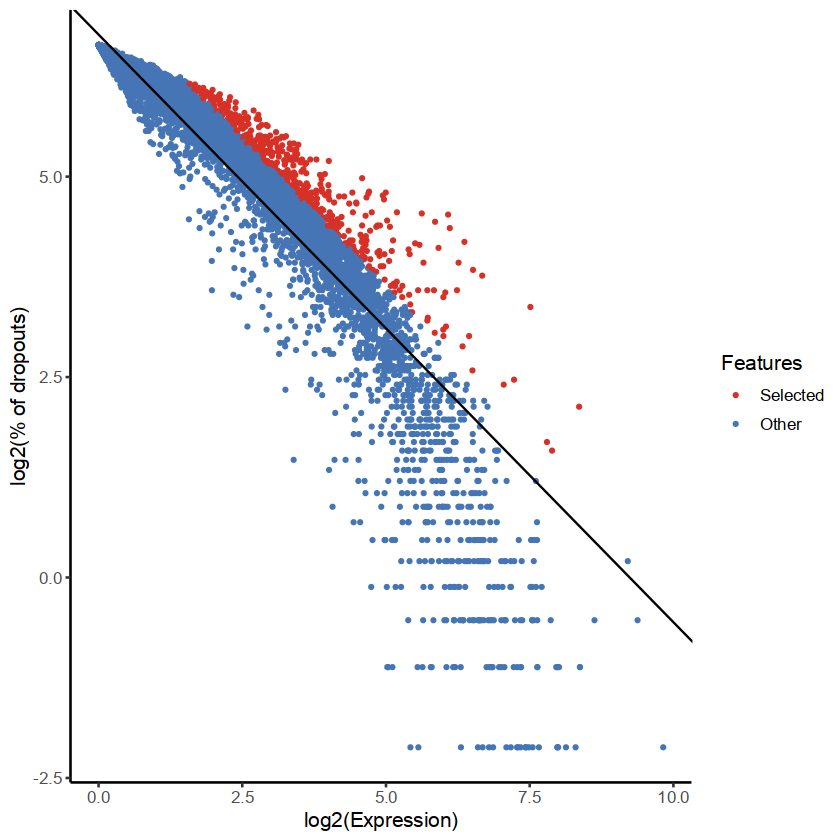

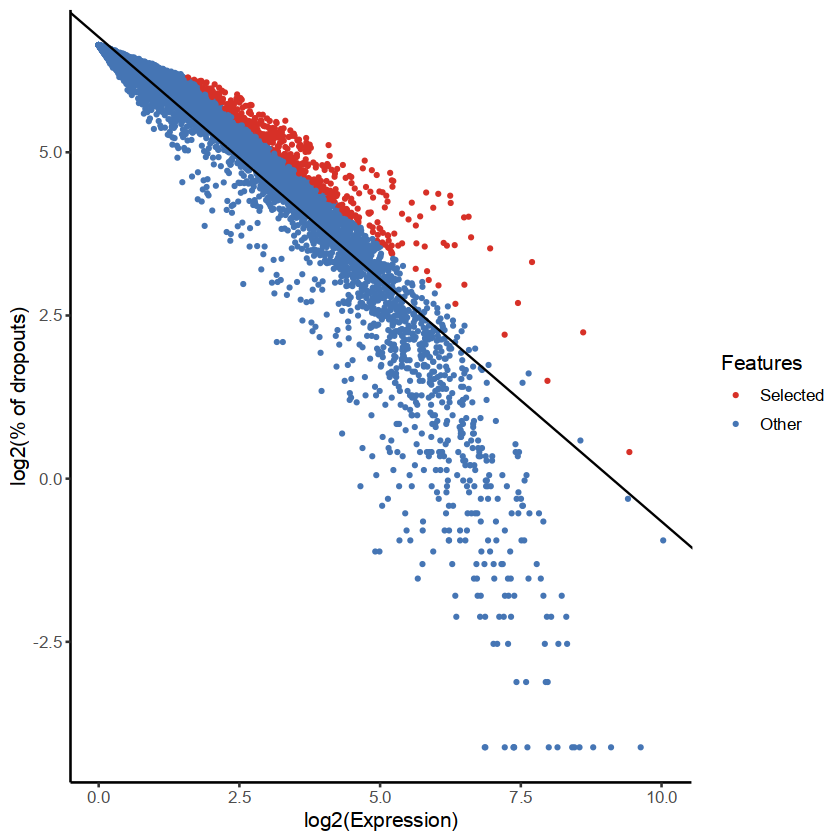

Fold 3 : Train samples = 1734 , Test samples = 434 Accuracy: 0.9585253 F1 score: 0.9725414 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



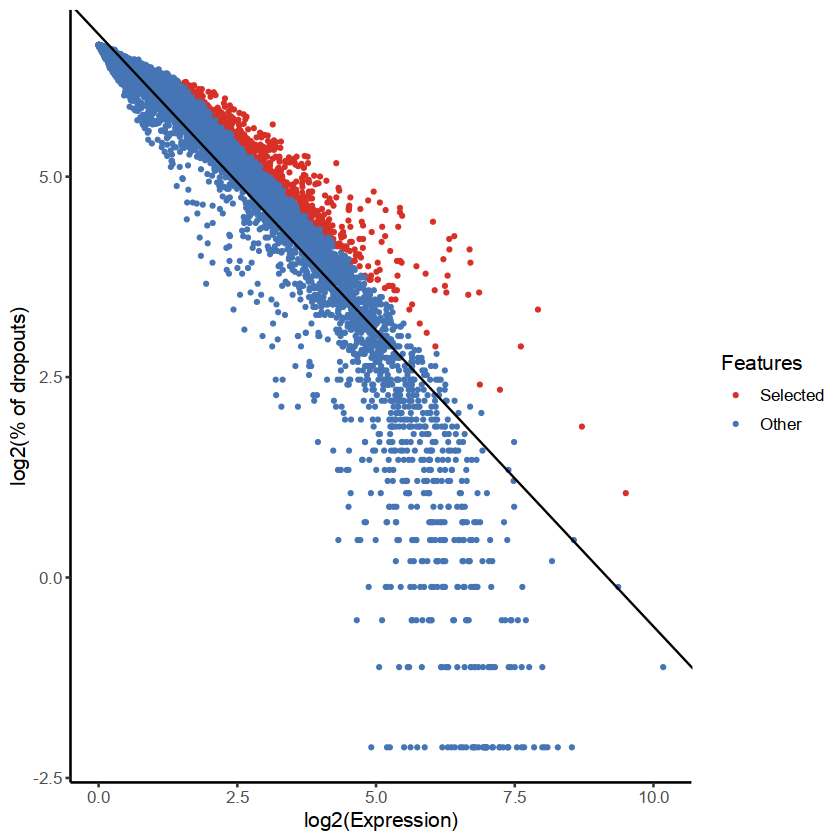

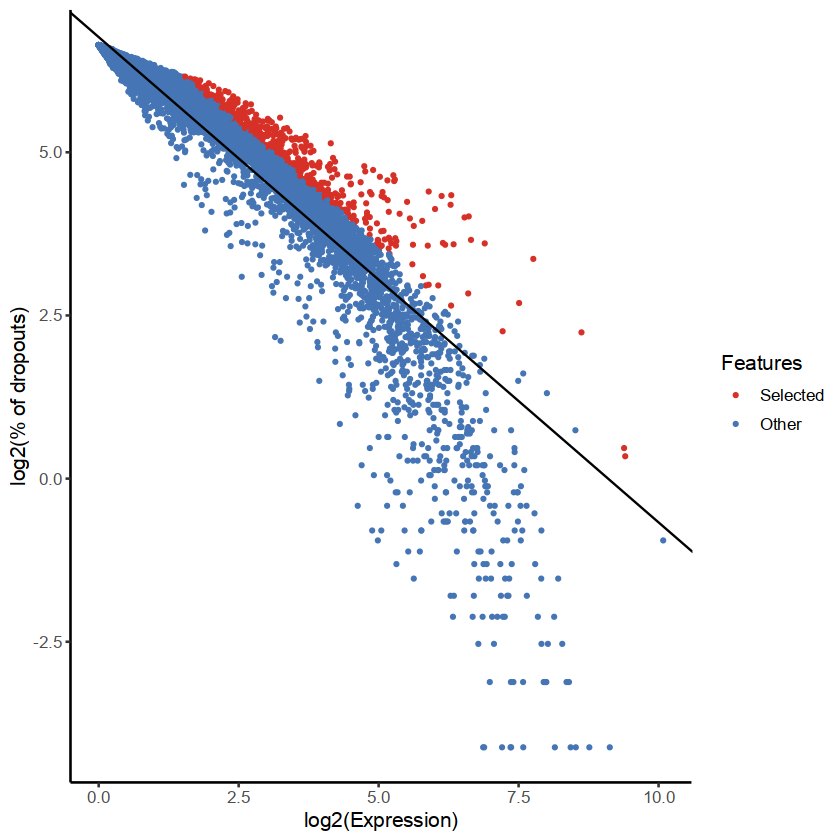

Fold 4 : Train samples = 1735 , Test samples = 433 Accuracy: 0.9630485 F1 score: 0.9821164 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



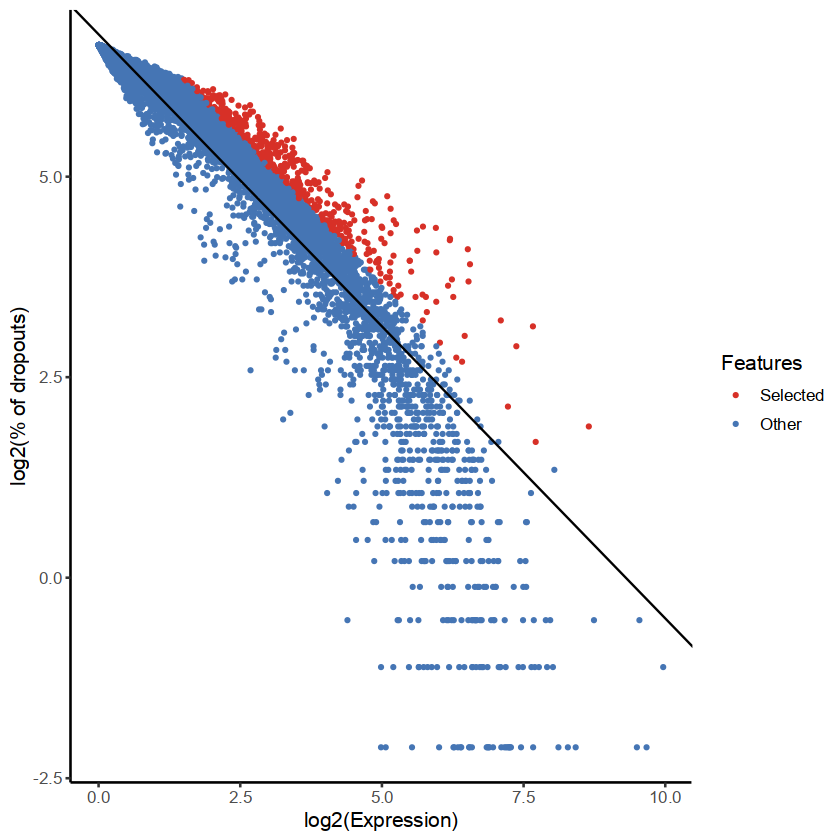

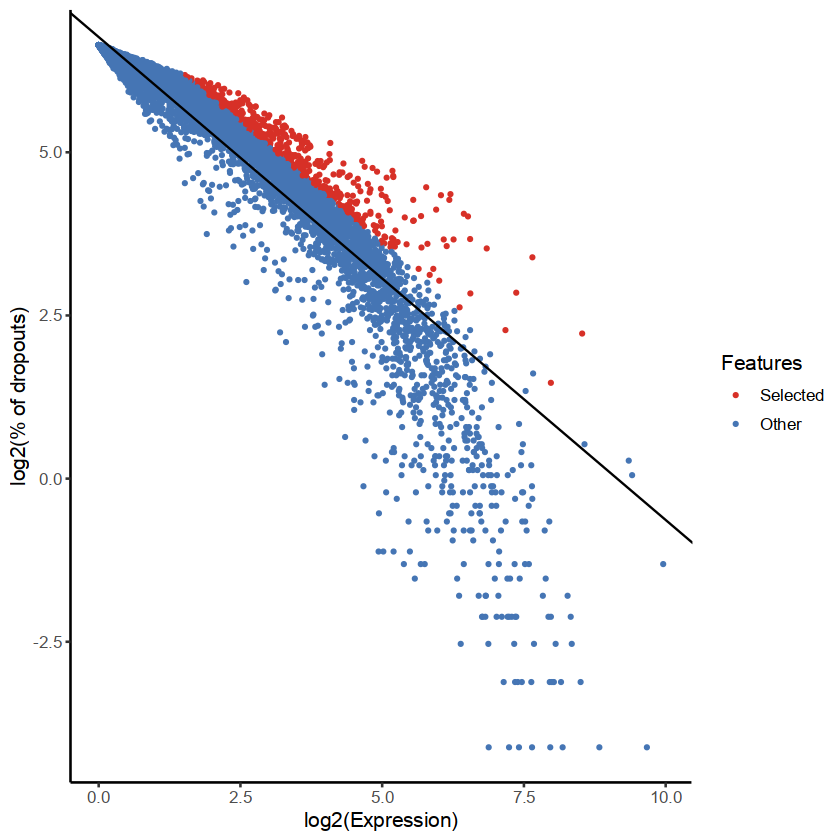

Fold 5 : Train samples = 1735 , Test samples = 433 Accuracy: 0.9515012 F1 score: 0.9143231 


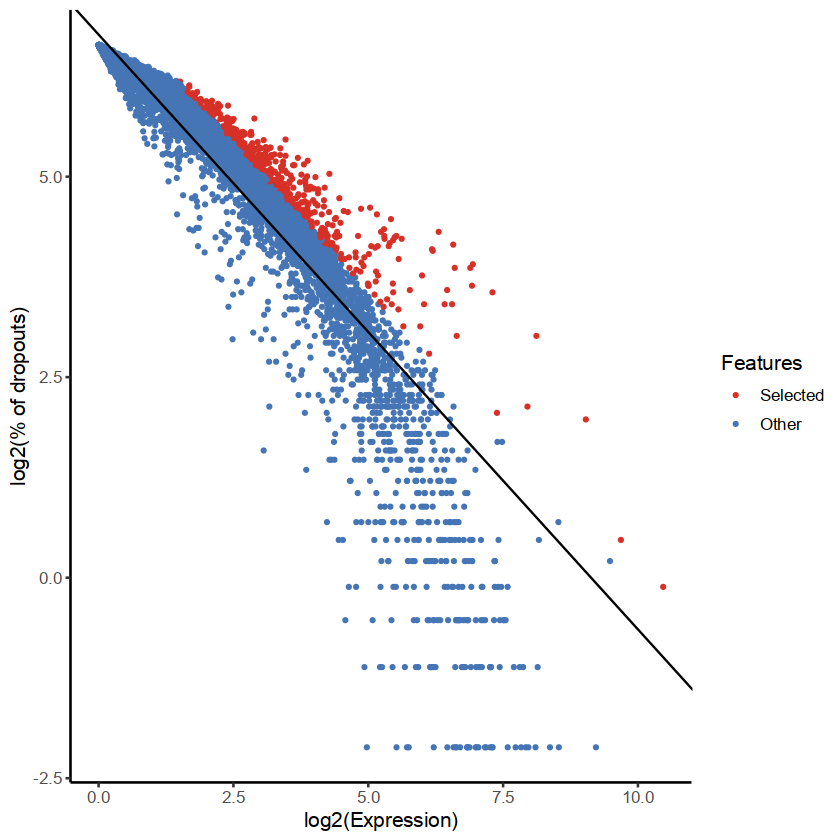

In [51]:
library(SingleCellExperiment)
library(scmap)

num_folds <- 5

# Generate 5-fold cross-validation indices
fold_indices <- split(sample(nrow(data)), 1:num_folds)

# Perform 5-fold cross-validation
for (i in 1:num_folds) {
  # Get indices for the current fold
  test_indices <- fold_indices[[i]]
  train_indices <- unlist(fold_indices[-i])
  
  # Subset data and annotation based on indices
  data_train <- data[train_indices, ]
  anno_train <- annotation[train_indices, ]
  
  data_test <- data[test_indices, ]
  anno_test <- annotation[test_indices, ]

  anno_train$cell_type1=anno_train$celltype

  reference = SingleCellExperiment(assays = list(counts = t(data_train)),colData = anno_train["cell_type1"])

  logcounts(reference) <- log2(counts(reference) + 1)

  rowData(reference)$feature_symbol <- rownames(reference)
  
  reference <- selectFeatures(reference, suppress_plot = FALSE)

  reference <- indexCell(reference)



  query = SingleCellExperiment(assays = list(counts = t(data_test)))

  logcounts(query) <- log2(counts(query) + 1)

  rowData(query)$feature_symbol <- rownames(query)

  query <- selectFeatures(query, suppress_plot = FALSE)

  #query <- indexCluster(query)



  scmapCell_results <- scmapCell(
  query, 
  index_list = list(
    yan = metadata(reference)$scmap_cell_index
    )
  )

  scmapCell_clusters <- scmapCell2Cluster(
  scmapCell_results, 
  list(
    as.character(colData(reference)$cell_type1)
  )
    )
    predictions=as.vector(scmapCell_clusters$scmap_cluster_labs)

  acc = calculate_test_accuracy(predictions,anno_test$celltype)
  f1_score = calculate_f1_score_multiclass(predictions,anno_test$celltype)

  cat("Fold", i, ": Train samples =", nrow(data_train), ", Test samples =", nrow(data_test), "Accuracy:", acc,"F1 score:", f1_score, "\n")

}

In [47]:
scmapCell_results$scmap_cluster_labs

NULL

yan
Acinar cells
Alpha cells
Alpha cells
Alpha cells
Alpha cells
Alpha cells
Ductal cells
Pancreatic stellate cells
Gamma (PP) cells
unassigned
